# Objective

This project serves as an extension of a previous ticket classification project, which initially employed deep learning models. The goal of this new approach is to apply Llama 3.1, a state-of-the-art large language model (LLM), for improving the ticket classification process. By leveraging the power of LLMs, the aim is to demonstrate how these models can handle complex text data efficiently and at scale. Due to time and resource constraints, only a subset of the full dataset was used. This project highlights the potential of LLMs in real-world applications and showcases the ability to work with advanced AI technologies.

# Loading Libraries and other Utilities

In [ ]:
%%capture
# %pip install -U bitsandbytes
# %pip install -U transformers
# %pip install -U accelerate
# %pip install -U peft
%pip install -U trl

In [ ]:
# %%capture
# !pip install accelerate==0.27.2
# !pip install transformers==4.40.2

In [ ]:
#pip install -U peft transformers accelerate bitsandbytes

In [ ]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)

# Datasets
from datasets import Dataset, DatasetDict

# Models
from transformers import AutoModel, AutoTokenizer

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
# Functions
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

#python
import pandas as pd
import numpy as np
import torch
import os

# plots
import matplotlib.pyplot as plt
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


secret_value_0 = os.environ.get("HF_TOKEN")

In [ ]:



MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"


# Lora R, rank of matrices. Lower values result in smaller matrices. Hence, less values to update
LORA_R = 16
# Lora Alpha is a scale of weight matrices. the weight matrices are scaled by LORA_R/LORA_ALPHA ( 16 )
LORA_ALPHA = 16
# Dropout probabilities for lora layers
LORA_DROPOUT = 0.05
# Parameters to specify if the bias should be trainable
LORA_BIAS = 'none'

# Loading Data

In [ ]:
# Loading Dataset
data = pd.read_csv('IT_Support_Tickets.csv')

data.dropna(how='all',inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(31657, 2)

In [ ]:
# due to resource constraints a portion of the data will be considered.
data = data.sample(int( 0.24*(data.shape[0])))

# Dataset creation

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7597 entries, 34948 to 3299
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Issue_Description  7597 non-null   object
 1   Category           7597 non-null   object
dtypes: object(2)
memory usage: 178.1+ KB


In [ ]:
data['Category'].value_counts()

Category
Hardware      3361
HR Support    2567
Access        1669
Name: count, dtype: int64

In [ ]:
# Encoding labels
data.replace({'Category':{"Hardware":0,
               "Access":1,
               "HR Support":2}},inplace=True)


# Transforming to Dataset class
dfh = Dataset.from_dict({
    "desc": data['Issue_Description'],
    "labels": data['Category']})

# Spliting into train/validation sets
dfh = dfh.train_test_split(test_size=0.2,shuffle = True )

dfx  = DatasetDict({
    'train': dfh['train'],
    'valid': dfh['test']
})

# Visualizations

In [ ]:
dfx.set_format(type = 'pandas')
df = dfx['train'][:]

In [ ]:
df.columns

Index(['desc', 'labels'], dtype='object')

In [ ]:
df.replace({'labels':{0:"Hardware",
               1:"Access",
               2:"HR Support"}},inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'No. of Issues')

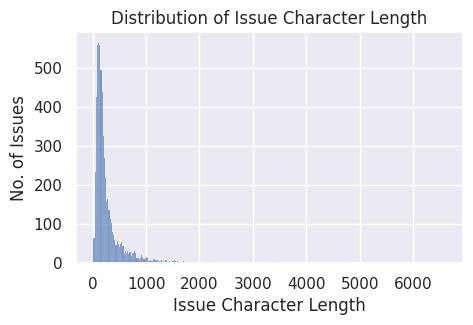

In [ ]:
char_len=[len(x) for x in df['desc']]
plt.figure(figsize=[5,3])
sns.histplot(data = char_len)
plt.title('Distribution of Issue Character Length')
plt.xlabel('Issue Character Length')
plt.ylabel('No. of Issues')

<Axes: xlabel='labels', ylabel='size'>

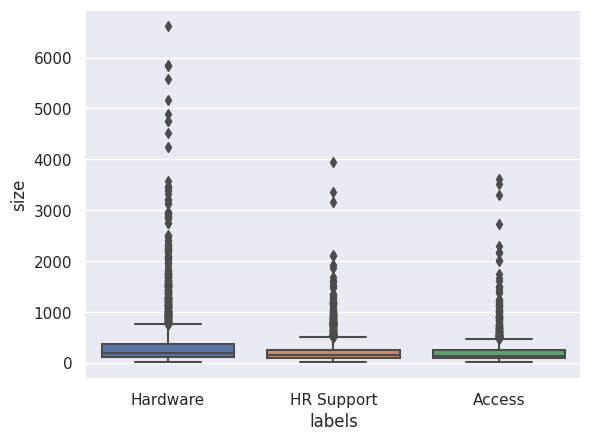

In [ ]:
import seaborn as sns
df['size'] = (df['desc'].apply(len))
sns.boxplot(data = df, x = 'labels', y = 'size')

In [ ]:
dfx.reset_format()

# Loading Model

In [ ]:
# bits and byts config,
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

In [ ]:
# Load model from pretrained
model =  AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config,
    token = secret_value_0,
    num_labels = 3
)


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Lla

In [ ]:

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL,token = secret_value_0)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token


model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

# Tokenizing

In [ ]:
def preprocessor_tokenizer(examples):
    return tokenizer(examples['desc'], truncation=True, max_length=512)

tokenized_datasets = dfx.map(preprocessor_tokenizer, batched=True)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/6077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1520 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['desc', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6077
    })
    valid: Dataset({
        features: ['desc', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1520
    })
})

# Model Training and Evaluation

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
y_true = dfx['valid']['labels']
y_train_true = dfx['train']['labels']

In [ ]:
lora_config = LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    target_modules = ['q_proj', 'k_proj', 'v_proj','o_proj'],
    lora_dropout = LORA_DROPOUT,
    bias = LORA_BIAS,
    task_type = 'SEQ_CLS'
)


bnb_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [ ]:
model.print_trainable_parameters()

trainable params: 13,643,776 || all params: 7,518,580,736 || trainable%: 0.1815


In [ ]:

training_args = TrainingArguments(
    output_dir = 'finetuning_llama3',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 1,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    push_to_hub=False,
    report_to = 'none'
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['valid'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

/tmp/ipykernel_96/3431620629.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer_output = trainer.train()
trainer_output.metrics

/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.600900,0.298940,0.894737,0.894622


/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-67d49828-7ba5950b5cfa3e991babad07;a211a695-9d73-40ae-8ba3-608594013c41)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct/resolve/main/config.json.
Access to model meta-llama/Llama-3.1-8B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Meta-Llama-3.1-8B-Instruct.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Meta-Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Req

{'train_runtime': 13136.6128,
 'train_samples_per_second': 0.463,
 'train_steps_per_second': 0.058,
 'total_flos': 3.721536001376256e+16,
 'train_loss': 0.5075661207500257,
 'epoch': 1.0}

In [ ]:
y_pred_pr = trainer.predict(tokenized_datasets["valid"])
y_pred = np.argmax(y_pred_pr.predictions, axis = 1)

In [ ]:
accuracy_score(y_true, y_pred)

0.8947368421052632

In [ ]:
f1_score(y_true, y_pred,average='weighted')

0.8946224430248619

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)


report_df = pd.DataFrame(report).transpose()


print(report_df)

              precision    recall  f1-score      support
0              0.878613  0.922610  0.900074   659.000000
1              0.929260  0.852507  0.889231   339.000000
2              0.895551  0.886973  0.891242   522.000000
accuracy       0.894737  0.894737  0.894737     0.894737
macro avg      0.901141  0.887364  0.893515  1520.000000
weighted avg   0.895726  0.894737  0.894622  1520.000000


# Conclusion

The project showcases the potential of large language models, like Llama 3.1, in tackling ticket classification tasks. It builds on a previous project, where deep learning models were employed, and demonstrates how LLMs can improve performance even with a smaller portion of the dataset. While the model's results are based on limited data, the achieved accuracy and F1 score of 0.8947 and 0.8946 respectively suggest the model’s strong potential. With more data and resources, it is expected that the performance would further improve, solidifying the practical application of LLMs for text classification. This project illustrates the ability to work with advanced AI technologies and adapt to the evolving landscape of natural language processing.